In [142]:
%matplotlib notebook
import re
import math
import matplotlib.pyplot as plt

In [38]:
VECTOR_PATTERN_STR = r'<\s*(-?\d+),\s*(-?\d+)>'
STAR_PATTERN_STR = r'position={0} velocity={0}'.format(VECTOR_PATTERN_STR)
STAR_PATTERN = re.compile(STAR_PATTERN_STR)

In [44]:
class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return '{}, {}'.format(self.x, self.y)

In [81]:
class Star:
    def __init__(self, pos, vel):
        self.pos = pos
        self.vel = vel
    
    def update(self, dt=1):
        self.pos.x += self.vel.x * dt
        self.pos.y += self.vel.y * dt
    
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return 'position=<{}> velocity=<{}>'.format(self.pos, self.vel)

In [147]:
class Simulation:
    def __init__(self):
        self.stars = []
        self.reset_bounding_box()
        self.elapsed_time = 0
        
    def add_star(self, star):
        self.check_bounding_box(star)
        self.stars.append(star)
    
    def update(self, dt=1):
        self.reset_bounding_box()
        self.elapsed_time += dt
        for star in self.stars:
            star.update(dt)
            self.check_bounding_box(star)
    
    def reset_bounding_box(self):
        self.x_min = +math.inf
        self.x_max = -math.inf
        self.y_min = +math.inf
        self.y_max = -math.inf
    
    def check_bounding_box(self, star):
        if star.pos.x < self.x_min:
            self.x_min = star.pos.x
        elif star.pos.x > self.x_max:
            self.x_max = star.pos.x
        if star.pos.y < self.y_min:
            self.y_min = star.pos.y
        elif star.pos.y > self.y_max:
            self.y_max = star.pos.y
            
    def get_bounding_box_size(self):
        width  = int(self.x_max-self.x_min+1)
        height = int(self.y_max-self.y_min+1)
        return (width, height)
    
    def get_grid(self):
        width, height = self.get_bounding_box_size()
        grid = [[0 for _ in range(width)] for _ in range(height)]
        for star in self.stars:
            x_pos = int(star.pos.x-self.x_min)
            y_pos = int(star.pos.y-self.y_min)
            grid[y_pos][x_pos] = 1
        return grid

In [159]:
class SimulationBrowser:
    def __init__(self, sim, rate=1):
        self.sim = sim
        self.rate = 1
        self.figure = plt.figure()
        self.figure.canvas.mpl_connect('key_press_event', self.key_press_event)
        self.ax = self.figure.add_subplot(1,1,1)
        self.draw()
    
    def key_press_event(self, event):
        if event.key == 'right':
            self.sim.update(self.rate)
        elif event.key == 'left':
            self.sim.update(-self.rate)
        else:
            return
        self.draw()
        self.figure.canvas.draw()
    
    def draw(self):
        self.ax.clear()
        self.ax.set_title('{:02f} seconds'.format(self.sim.elapsed_time))
        self.ax.imshow(self.sim.get_grid())

In [83]:
filepath = 'data/day10.txt'

In [131]:
def get_stars(filepath):
    with open(filepath) as file:
        for line in file.readlines():
            match = STAR_PATTERN.findall(line)[0]
            pos_x, pos_y = int(match[0]), int(match[1])
            vel_x, vel_y = int(match[2]), int(match[3])
            yield Star(Vector(pos_x, pos_y), Vector(vel_x, vel_y))

In [148]:
def perform_simulation(filepath, threshold=1000):
    stars = list(get_stars(filepath))
    sim = Simulation()
    for star in stars:
        sim.add_star(star)
    min_area, time = math.inf, 0
    # get approx from first star
    # velocity*time + position = 0
    # time = -position/velocity
    time = -stars[0].pos.x/stars[0].vel.x
    time = int(time*0.95)
    print('Fast forwarding to: {}'.format(time))
    sim.update(time)
    # now continue simulation until min is lost
    for i in range(1000):
        sim.update(1)
        width, height = sim.get_bounding_box_size()
        area = width*height
        # if shrinking area, continue
        if area < min_area:
            min_area = area
            time = sim.elapsed_time
        # if area grew, stop simulation
        else:
            break
    print('Updating to: {}'.format(time))
    print('Bounding box size: {}x{}'.format(*sim.get_bounding_box_size()))
    return sim

In [149]:
sim = perform_simulation(filepath)

Fast forwarding to: 10289
Updating to: 10880
Bounding box size: 70x20


<IPython.core.display.Javascript object>


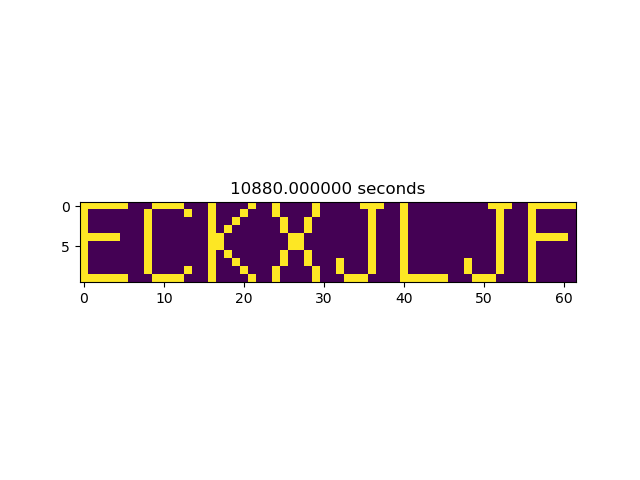

In [160]:
browser = SimulationBrowser(sim)